### This notebook uses the data loading and additional data exploration, building up on the notebooks used during ForceSMIP hackathon. Data loading, processing and ML codes were newly developed and added here ###

In [ ]:
# I/O / data wrangling
import glob
import re
import numpy as np
import xcdat as xc
import xarray as xr
import gc

# runtime metrics
import time as clocktime

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

In [3]:
# plotting
import matplotlib.pyplot as plt

In [4]:
def fig_size(W=15,H=5) :

    import matplotlib.pylab as pylab
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (W, H),
             'axes.labelsize': 'xx-large',
             'axes.titlesize':'xx-large',
             'xtick.labelsize':'xx-large',
             'ytick.labelsize':'xx-large'}
    pylab.rcParams.update(params)
    
fig_size(W=15,H=10)

In [5]:
import pandas as pd

In [8]:
# tensorflow for NN
import tensorflow as tf
import keras

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
# from sklearn.cross_decomposition import PLSRegression
import random
from scipy import stats
import statsmodels.api as sm

In [11]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

### Define some static mappings for CMIP/ForceSMIP data

This is just some helper information to helps us search for data and reshape it. All ForceSMIP data is on a 2.5 x 2.5 degree lat/lon grid. 

In [12]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

### Define user-specified parameters

In [13]:
# root_dir = "/net/krypton/climdyn_nobackup/FTP/ForceSMIP/"  # path to forcesmip data (ETH)
root_dir     = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"  # path to forcesmip data (NCAR)

# n_members = 10  # number of members for training
ncvar = "pr" # variable to be used: pr, psl, tas, zmta, tos, siconc, monmaxpr, monmaxtasmax, monmintasmin
# reference_period = ("1950-01-01", "1999-12-31") # climatological period (for anomaly calculations)
reference_period = ("1980-01-01", "1999-12-31") # climatological period (for anomaly calculations)

# choose models for training / validation
# choices include: 'CESM2', 'CanESM5', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR'
# training_models = ["CESM2", "CanESM5", "MIROC6", "MPI-ESM1-2-LR"]
# testing_models = ["MIROC-ES2L"]
# training_models = ["MIROC-ES2L", "CESM2", "CanESM5", "MIROC6"]
# testing_models = ["MPI-ESM1-2-LR"]

training_models = ["CESM2", "CanESM5", "MIROC6", "MPI-ESM1-2-LR", "MIROC-ES2L"]
testing_models  = []

# choose number of members for training / validation
n_members_train = 20
n_members_val   = 4

# MIROC-ES2L (30 members)
# CESM2 (50 members)
# CanESM5 (25 members)
# MIROC6 (50 members)
# MPI-ESM1-2-LR (30 members)


# choose evaluation data
eval_tier = "Tier1"  # Tier1, Tier2, or Tier3
tv_time_period = evalPeriods[eval_tier]  # populates based on the evaluation data tier, but can be overwritten (with a tuple of date strings)

### Define a function to read in data

We're going to loop over many models and realizations for a) training, b) validation, and c) evaluation data. To make this more readable and to reduce repeating code, we are going to define a function to do this operation.

In [15]:
def load_realization(fn, vid, time_period, reference_period):
    """
    load_realization(fn, vid, time_period, reference_period)
    
    Function loads in data for a given file, fn, and variable, vid. It
    selects data for a given time_period and calculates the annual anomalies
    relative to a user-defined reference_period. The function returns the 3D
    anomaly map, and the global mean time series. 
    
    Inputs:
    -------
    fn (str) : filename
    vid (str) : variable id
    time_period (tuple(str, str)) : tuple of the start and end of the time period
                                    e.g., ("1900-01-01", "1949-12-31")
    reference_period (tuple(str, str)) : tuple of the start and end of the reference period
                                         used to calculate anomalies e.g., ("1900-01-01", "1949-12-31")
                                         
    Returns:
    --------
    ts_3d (xr.DataArray) : annual average anomaly values [time, lat, lon]
    ts_gm (xr.DataArray) : annual average, global mean anomaly values
    """
    # open dataset
    ds = xc.open_dataset(fn)
    ds = ds.bounds.add_missing_bounds(axes=["X", "Y", "T"])
    # if specified, subset training/validation data to specific period
    if tv_time_period is not None:
        ds = ds.sel(time=slice(time_period[0], time_period[1]))
    # get departures
    ds = ds.temporal.departures(vid, freq="month", reference_period=reference_period)
    # take annual average
    # Note: xcdat takes the annual average ignoring NaN values
    ds = ds.temporal.group_average(vid, freq="year", weighted=False)
    ts_3d = ds[vid]
    # take spatial average
    ds = ds.spatial.average(vid)
    ts_gm = ds[vid]
    # clean up 
    ds.close()
    # return values
    return ts_3d, ts_gm

### Read in evaluation data

We start with the evaluation data, because this data includes observations...and missing data. We will load the evaluation data and create a missing data mask, which we will apply to the training/evaluation data as well. That way the training and evaluation data will be consistent. We store data in a nested dictionary (with the model names as keys). 

*Important note*: we use annual averages in this notebook (which hides missing monthly values). A better method would be to mask at the monthly timescale. 

In [129]:
# first we search for the evaluation data
epath  = "/".join([root_dir, "Evaluation-" + eval_tier, cmipTable[ncvar], ncvar])
efiles = glob.glob(epath + "/*.nc")
efiles = sorted(efiles, key=natsort)

# initialize dictionary to store data
evaluation_annual_anomaly_maps = {}
vid = cmipVar[ncvar]

evaluation_annual_anomaly_data = []
evaluation_names = []

# loop over evaluation files
for im, fn in enumerate(efiles):
    # get evaluation identifier
    model = fn.split("/")[-1].split("_")[2].split(".")[0]
    # print progress
    print(str(im + 1) + " / " + str(len(efiles)) + ": " + model)
    # read in data for realization
    ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
    # store anomaly map
    evaluation_annual_anomaly_maps[model] = ts_3d

    evaluation_annual_anomaly_data.append(np.array(ts_3d))
    evaluation_names.append(model)
    
# create mask for missing data
missing_data_mask = np.nanmean(ts_3d, axis=0)
missing_data_mask = np.where(np.isnan(missing_data_mask), np.nan, 1)

1 / 10: 1A
2 / 10: 1B
3 / 10: 1C
4 / 10: 1D
5 / 10: 1E
6 / 10: 1F
7 / 10: 1G
8 / 10: 1H
9 / 10: 1I
10 / 10: 1J


### Loop over models and retrieve global mean time series and anomaly maps
We store data in a nested dictionary (with the model and member names as keys). 

In [21]:
# training_models = ["CESM2", "CanESM5", "MIROC6", "MPI-ESM1-2-LR"]
# testing_models  = ["MIROC-ES2L"]

training_models = ["CESM2", "CanESM5", "MIROC-ES2L", "MPI-ESM1-2-LR","MIROC6"]
testing_models  = []

all_models      = training_models + testing_models

In [22]:
### listing the members : 

# YR1, YR2 = 1950, 2020
YR1, YR2 = 1950, 2100

members_list = []
all_data     = []

all_data_trend = []

# loop over models
models = all_models

for im, model in enumerate(models):
# for im, model in enumerate(models[1:2]):
    model_data       = []
    model_data_trend = []
    
    # start timer
    stime = clocktime.time()
    # initialize nested dictionary for model data


    # get model files
    # mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
    mpath = "/".join([root_dir, "Training-Ext", cmipTable[ncvar], ncvar, model])
    mfiles = glob.glob(mpath + "/*.nc")
    # parse file names to get list of model members
    # CESM2 has a non-CMIP naming convention
    if model == "CESM2":
        members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
    else:
        members = [p.split("_")[-1].split(".")[0] for p in mfiles]
    members = sorted(members, key=natsort)

    members_list.append(members)

    print(mfiles[0])

    for n_mem in range(0,len(members)) :
        filename = mfiles[n_mem]
        print(filename)
        file_xr = xr.open_dataset(filename)[ncvar]
        file_xr = file_xr.groupby('time.year').mean('time')
        file_xr = file_xr.sel(year=slice(str(YR1)+'-01-01',str(YR2)+'-12-31'))
        model_data.append(file_xr)

        # get actual trend map
        ts_3d = file_xr
        nt    = ts_3d.shape[0]
        time  = np.arange(1,nt+1)
        ts_3d = np.reshape(np.array(ts_3d), (nt, nlat*nlon))
        tmap, b = np.polyfit(time, ts_3d, 1)
        tmap *= 10  # to K/decade units
        tmap  = np.reshape(tmap, (nlat, nlon))
        model_data_trend.append(tmap)

    all_data.append(xr.concat(model_data, dim='member'))
    all_data_trend.append(model_data_trend)
            

/glade/campaign/cgd/cas/asphilli/ForceSMIP//Training-Ext/Amon/pr/CESM2/pr_mon_CESM2_historical_ssp370_r1301.016i1p1f1.188001-210012.nc
/glade/campaign/cgd/cas/asphilli/ForceSMIP//Training-Ext/Amon/pr/CESM2/pr_mon_CESM2_historical_ssp370_r1301.016i1p1f1.188001-210012.nc
/glade/campaign/cgd/cas/asphilli/ForceSMIP//Training-Ext/Amon/pr/CESM2/pr_mon_CESM2_historical_ssp370_r1231.011i1p1f1.188001-210012.nc
/glade/campaign/cgd/cas/asphilli/ForceSMIP//Training-Ext/Amon/pr/CESM2/pr_mon_CESM2_historical_ssp370_r1231.020i1p1f1.188001-210012.nc
/glade/campaign/cgd/cas/asphilli/ForceSMIP//Training-Ext/Amon/pr/CESM2/pr_mon_CESM2_historical_ssp370_r1301.012i1p1f1.188001-210012.nc
/glade/campaign/cgd/cas/asphilli/ForceSMIP//Training-Ext/Amon/pr/CESM2/pr_mon_CESM2_historical_ssp370_r1301.019i1p1f1.188001-210012.nc
/glade/campaign/cgd/cas/asphilli/ForceSMIP//Training-Ext/Amon/pr/CESM2/pr_mon_CESM2_historical_ssp370_r1251.014i1p1f1.188001-210012.nc
/glade/campaign/cgd/cas/asphilli/ForceSMIP//Training-Ex

In [25]:
ens_averages       = []
ens_averages_trend = []

for ds in all_data:
    # Assuming your data variable is named 'data_var', replace 'data_var' with your actual variable name
    ens_mean = ds.mean(dim=['member'])
    print(ens_mean)
    ens_averages.append(ens_mean)

    # get actual trend map
    ts_3d = ens_mean
    nt    = ts_3d.shape[0]
    time  = np.arange(1,nt+1)
    ts_3d = np.reshape(np.array(ts_3d), (nt, nlat*nlon))
    tmap, b = np.polyfit(time, ts_3d, 1)
    tmap *= 10  # to K/decade units
    tmap  = np.reshape(tmap, (nlat, nlon))
    ens_averages_trend.append(tmap)

<xarray.DataArray 'pr' (year: 150, lat: 72, lon: 144)>
array([[[0.18772639, 0.18738736, 0.18673315, ..., 0.18974958,
         0.18922348, 0.18838269],
        [0.14063465, 0.13859672, 0.13619607, ..., 0.1482106 ,
         0.14517767, 0.14260561],
        [0.13999442, 0.13544564, 0.12783592, ..., 0.17223929,
         0.16204595, 0.14855359],
        ...,
        [0.8390931 , 0.83884701, 0.841862  , ..., 0.875115  ,
         0.86179136, 0.84475737],
        [0.72863371, 0.72919501, 0.72926245, ..., 0.71757218,
         0.72267909, 0.72674335],
        [0.65373598, 0.65483632, 0.6569511 , ..., 0.64599652,
         0.64813518, 0.6514709 ]],

       [[0.17676039, 0.17642218, 0.17574729, ..., 0.17896388,
         0.17836858, 0.17741992],
        [0.12708508, 0.12476617, 0.12216278, ..., 0.13661502,
         0.13332092, 0.1300057 ],
        [0.13323001, 0.12854635, 0.120544  , ..., 0.16408557,
         0.15460462, 0.14163799],
...
        [1.14640024, 1.14537657, 1.14887704, ..., 1.21053253,


In [26]:
years = np.array(all_data[0].year)
years

array([1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038,
       2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049,
       2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060,
       2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071,
       2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082,
       2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093,
       2094, 2095, 2096, 2097, 2098, 2099, 2100])

In [29]:
lowess_yr       = 30
frac_lowess     = lowess_yr/len(years)
num_time_series = 1

In [30]:
### below the synthetic_ens_average_all is actual data. It will be expanded with synthetic data in future work. 

synthetic_ens_average_all       = []

for ds in all_data:
    ens_mean = np.array(ds.mean(dim=['member']))
    # print(ens_mean)
    synthetic_ens_average_all.append(ens_mean)

synthetic_ens_average_all = np.array(synthetic_ens_average_all)
synthetic_ens_average_all = np.expand_dims(synthetic_ens_average_all,axis=1)
synthetic_ens_average_all.shape

(5, 1, 150, 72, 144)

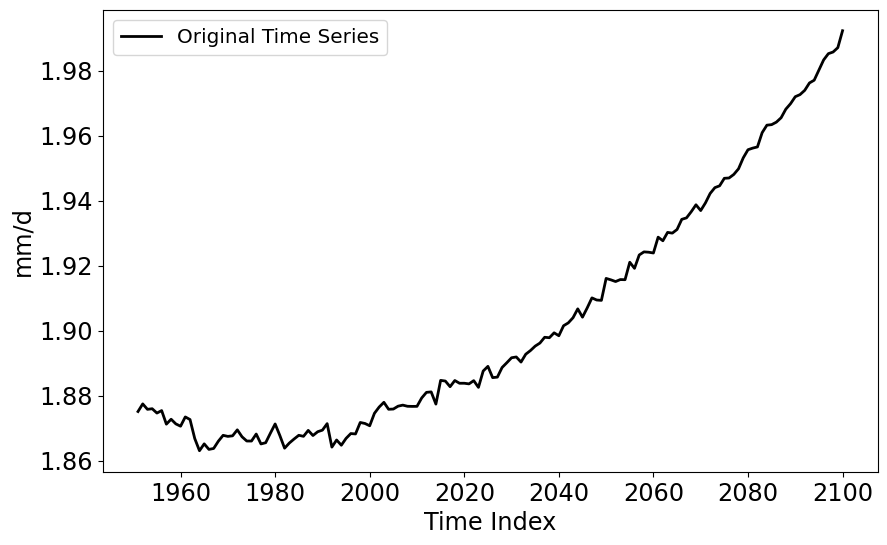

In [31]:
# Plotting
plt.figure(figsize=(10, 6))

YY = synthetic_ens_average_all[0]*np.expand_dims(weights,axis=(0,1,3))
YY = np.nanmean(YY,axis=(2,3))

plt.plot(years, (ens_averages[0]*weights).mean(('lat','lon')), label='Original Time Series', linewidth=2, color='black')

if num_time_series > 1 :
    for i in range(num_time_series):
        if i == 0  :
            plt.plot(years,YY[i], color='grey', alpha=0.2, label='scaled timeseries with a standard Gaussian distribution')
        else :
            plt.plot(years,YY[i], color='grey', alpha=0.2)
    
# plt.title('Original and scaled global mean ensemble mean pr time Series')
plt.xlabel('Time Index')
plt.ylabel('mm/d')
plt.legend()
plt.show()

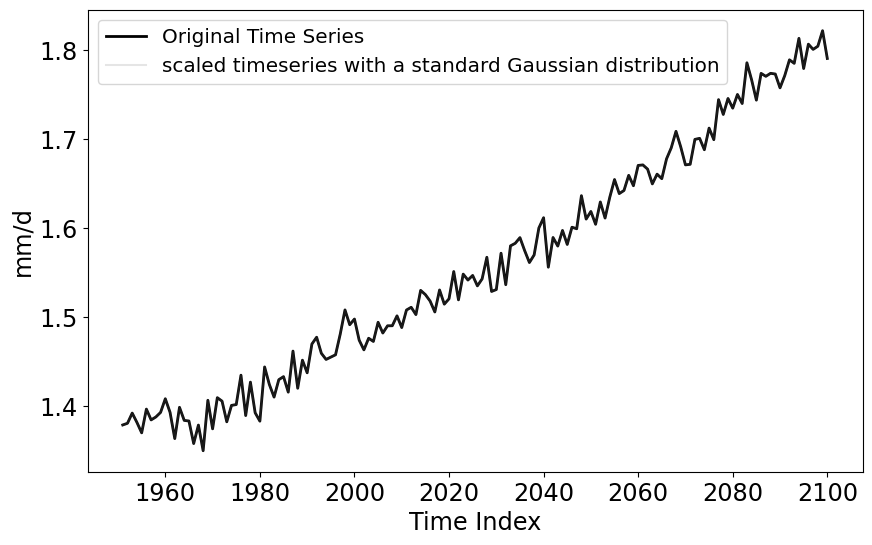

In [32]:
# for a random location :

ilat, ilon = 10, 20

# Plotting
plt.figure(figsize=(10, 6))

YY = synthetic_ens_average_all[0]*np.expand_dims(weights,axis=(0,1,3))
# YY = np.nanmean(YY,axis=(2,3))
YY = YY[:,:,ilat,ilon]

plt.plot(years, (ens_averages[0]*weights).isel(lat=ilat,lon=ilon), label='Original Time Series', linewidth=2, color='black')

for i in range(num_time_series):
    if i == 0  :
        plt.plot(years,YY[i], color='grey', alpha=0.2, label='scaled timeseries with a standard Gaussian distribution')
    else :
        plt.plot(years,YY[i], color='grey', alpha=0.2)
    
# plt.title('Original and scaled global mean ensemble mean pr time Series')
plt.xlabel('Time Index')
plt.ylabel('mm/d')
plt.legend()
plt.show()

In [33]:
model_indices = np.arange(len(ens_averages))

# Split indices into 4 for training and 1 for testing
training_indices = model_indices[:]
# testing_indices  = model_indices[4]

## Extract training and testing data
training_data_unforced  = [ np.array(all_data[i]-ens_averages[i]) for i in training_indices]
# testing_data_unforced   = [ np.array(all_data[testing_indices]-ens_averages[testing_indices]) ]

In [34]:
training_indices

array([0, 1, 2, 3, 4])

In [35]:
train_X, train_y = [], []

for n_mod in range(len(training_indices)) :
    for n_syn in range(num_time_series) :
        print(n_mod, n_syn, end=' ')
        train_X.append(training_data_unforced[n_mod]+synthetic_ens_average_all[n_mod,n_syn])
        train_y.append( [synthetic_ens_average_all[n_mod,n_syn]]*len(members_list[n_mod]) )

train_X = [item for sublist in train_X for item in sublist]
train_y = [item for sublist in train_y for item in sublist]

train_X = np.array(train_X)
train_y = np.array(train_y)

train_X.shape, train_y.shape

0 0 1 0 2 0 3 0 4 0 

((185, 150, 72, 144), (185, 150, 72, 144))

In [36]:
# moving window calculation : 

Window_size = 10

from numpy.lib.stride_tricks import as_strided

def time_slices(aam, window_size=Window_size):
    # Original shape: (N, T, H, W)
    shape = aam.shape
    new_shape = shape[0], shape[1] - window_size + 1, shape[2], shape[3], window_size
    strides = aam.strides[:4] + (aam.strides[1],)
    
    # Create a strided array of windows along the second dimension (time)
    strided_aam = as_strided(aam, shape=new_shape, strides=strides)
    
    # No need to move axes, as the new array is already in the desired shape.
    return strided_aam

In [37]:
stime = clocktime.time()

train_X = time_slices(train_X)
train_y = time_slices(train_y)[:,:,:,:,-1]

# print time elapse for model
etime = clocktime.time()
print("Time elapsed: " + str(etime - stime) + " seconds")

train_X.shape, train_y.shape

Time elapsed: 0.00013780593872070312 seconds


((185, 141, 72, 144, 10), (185, 141, 72, 144))

In [38]:
train_X = train_X.reshape(-1,72,144,Window_size)
train_y = train_y.reshape(-1,72,144)

train_X = np.expand_dims(train_X,axis=-1)
train_y = np.expand_dims(train_y,axis=-1)

train_X.shape, train_y.shape

((26085, 72, 144, 10, 1), (26085, 72, 144, 1))

In [39]:
stime = clocktime.time()

# compute X/Y mean / standard deviation
X_mean = np.nanmean(train_X, axis=0)
X_std  = np.nanstd(train_X, axis=0)

# normalize
train_X = (train_X - X_mean) / X_std
train_X[np.isnan(train_X)] = 0

# print time elapse for model
etime = clocktime.time()
print("Time elapsed: " + str(etime - stime) + " seconds")

Time elapsed: 58.155333280563354 seconds


In [40]:
stime = clocktime.time()

# compute X/Y mean / standard deviation
Y_mean = np.nanmean(train_y, axis=0)
Y_std  = np.nanstd(train_y, axis=0)

# normalize
train_y = (train_y - Y_mean) / Y_std
train_y[np.isnan(train_y)] = 0

# print time elapse for model
etime = clocktime.time()
print("Time elapsed: " + str(etime - stime) + " seconds")

Time elapsed: 5.549352645874023 seconds


In [41]:
train_X.shape, train_y.shape

((26085, 72, 144, 10, 1), (26085, 72, 144, 1))

In [42]:
nt  = len(years)
nt

150

In [43]:
########################## training/testing NN ##############################

In [44]:
####### tuning #######

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperModel
from keras_tuner.tuners import Hyperband

class AdvancedUNetHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        inputs = Input(shape=self.input_shape)
        
        # Downsample 1
        c1 = Conv2D(
            hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), 
            hp.Choice('conv_1_kernel', values=[3, 5]), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_1_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(inputs)
        d1 = Dropout(hp.Float('dropout_1_rate', min_value=0.0, max_value=0.5, step=0.1))(c1)
        p1 = MaxPooling2D((2, 2))(d1)
        
        # Downsample 2
        c2 = Conv2D(
            hp.Int('conv_2_filters', min_value=64, max_value=256, step=64), 
            hp.Choice('conv_2_kernel', values=[3, 5]), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_2_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(p1)
        d2 = Dropout(hp.Float('dropout_2_rate', min_value=0.0, max_value=0.5, step=0.1))(c2)
        p2 = MaxPooling2D((2, 2))(d2)
        
        # Bottleneck
        b = Conv2D(
            hp.Int('bottleneck_filters', min_value=128, max_value=512, step=128), 
            (3, 3), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_bottleneck_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(p2)
        
        # Upsample 1
        u1 = UpSampling2D((2, 2))(b)
        concat1 = concatenate([u1, d2])
        c3 = Conv2D(
            hp.Int('conv_3_filters', min_value=64, max_value=256, step=64), 
            (3, 3), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_3_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(concat1)
        
        # Upsample 2
        u2 = UpSampling2D((2, 2))(c3)
        concat2 = concatenate([u2, d1])
        c4 = Conv2D(
            hp.Int('conv_4_filters', min_value=32, max_value=128, step=32), 
            (3, 3), activation='relu', padding='same',
            kernel_regularizer=l2(hp.Float('l2_4_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')))(concat2)
        
        # Output layer
        outputs = Conv2D(1, (1, 1), activation='linear')(c4)
        
        model = Model(inputs=[inputs], outputs=[outputs])
        
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mean_squared_error')
        
        return model


In [46]:
input_shape = (72, 144, Window_size)  # Example input shape
hypermodel = AdvancedUNetHyperModel(input_shape=input_shape)

tuner = Hyperband(
    hypermodel,
    objective='val_loss',
    max_epochs=10,
    directory='/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1',
    project_name='unet_tuning_Hyperband',
    max_consecutive_failed_trials=1,
)

# Calculate the number of samples to select (n% of the data)
num_samples = len(train_X)
num_samples_to_select = num_samples // 16  # Use integer division to get an integer result
random.seed(0)
random_indices = np.random.choice(num_samples, num_samples_to_select, replace=False)
ens_eval = 0

### below line should be uncommented for the tuning to commence. 
# tuner.search(train_X[random_indices], train_y[random_indices], epochs=10, batch_size=1, validation_data=(test_X[ens_eval], test_y[ens_eval]))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Reloading Tuner from /glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1/unet_tuning_Hyperband/tuner0.json


In [47]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 144, 10  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 72, 144, 96)  24096       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 72, 144, 96)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 36, 72, 96)   0           ['dropout[0][0]']            

In [48]:
# early stopping tracks the validation loss
es_train =  tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50, # if loss doesn't decrease for 5 epochs...
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=True,#... restore the best weights
            start_from_epoch=0
        )

In [49]:
history = model.fit(
    train_X, train_y,
    validation_split=0.2,  # Use 20% of the data for validation
    epochs=1000,  # Start with a few epochs
    batch_size=256,
    callbacks=[es_train]
)

Epoch 1/1000


2024-02-27 19:06:34.106927: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 49s 490ms/step - loss: 1.0094 - val_loss: 0.5984
Epoch 2/1000
82/82 [==============================] - 32s 395ms/step - loss: 0.5375 - val_loss: 0.4482
Epoch 3/1000
82/82 [==============================] - 33s 397ms/step - loss: 0.4210 - val_loss: 0.3672
Epoch 4/1000
82/82 [==============================] - 33s 397ms/step - loss: 0.3530 - val_loss: 0.3191
Epoch 5/1000
82/82 [==============================] - 32s 395ms/step - loss: 0.3077 - val_loss: 0.2860
Epoch 6/1000
82/82 [==============================] - 32s 394ms/step - loss: 0.2751 - val_loss: 0.2607
Epoch 7/1000
82/82 [==============================] - 32s 394ms/step - loss: 0.2509 - val_loss: 0.2423
Epoch 8/1000
82/82 [==============================] - 32s 395ms/step - loss: 0.2316 - val_loss: 0.2299
Epoch 9/1000
82/82 [==============================] - 32s 394ms/step - loss: 0.2182 - val_loss: 0.2117
Epoch 10/1000
82/82 [==============================] - 32s 394ms/step - loss: 0.2049 -

In [50]:
DIR = '/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1/unet_tuning_Hyperband/trained_model.keras'
# model.save(DIR+'trained_model_all_models.keras')

In [141]:
DIR = '/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1/unet_tuning_Hyperband/trained_model.keras'
model = tf.keras.models.load_model(DIR+'trained_model_all_models.keras')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 144, 10  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 72, 144, 96)  24096       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 72, 144, 96)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 36, 72, 96)   0           ['dropout[0][0]']            

In [52]:
# pd.DataFrame.from_dict(history.history).to_csv('/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1/unet_tuning_Hyperband/history_trained_model_all_models.csv',index=False)

In [53]:
history2 = pd.read_csv('/glade/work/gavinmad/forcesmip/notebooks/Gavin/models/testing/CNN/allgrids/3Dcnn_timeseries/trained/allgrids_v22f_v1/unet_tuning_Hyperband/history_trained_model_all_models.csv')#, index_col=0)
history2

,loss,val_loss
0,1.009399,0.598414
1,0.537462,0.448203
2,0.420990,0.367167
3,0.352988,0.319072
4,0.307706,0.285964
...,...,...
96,0.103564,0.121355
97,0.105902,0.133646
98,0.102076,0.134324
99,0.103474,0.130770


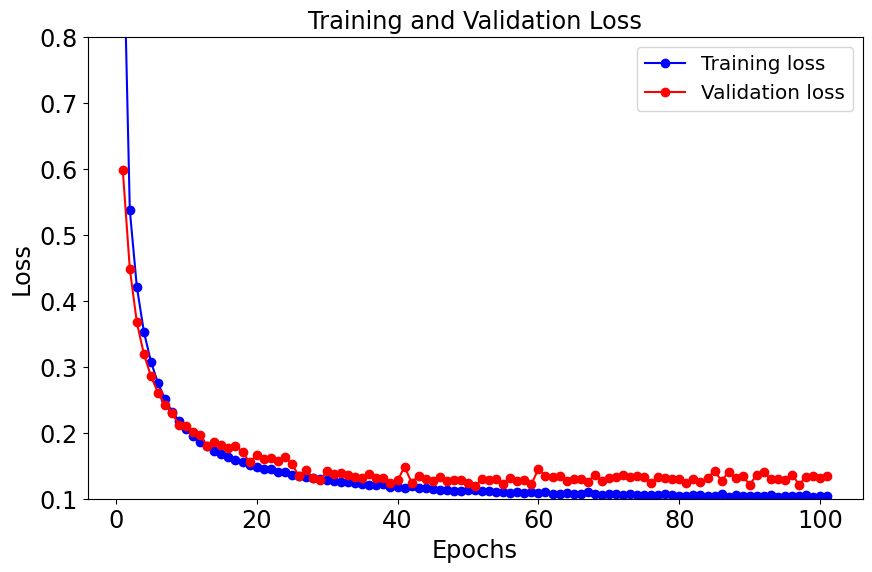

In [54]:
loss     = history2['loss']
val_loss = history2['val_loss']
epochs   = range(1, len(loss) + 1)
# 
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.ylim(0.1,0.8)

plt.show()

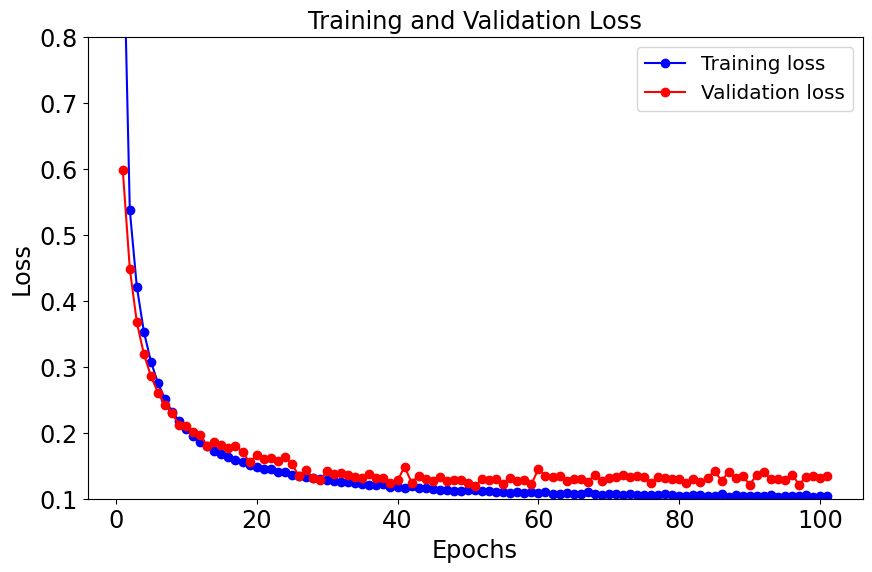

In [55]:
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(1, len(loss) + 1)
# 
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.ylim(0.1,0.8)

plt.show()